In [4]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

from collections import defaultdict
import numpy as np
import tensorflow as tf
import keras
from keras import layers
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
from PIL import Image

# Define the path to the directory containing the images
data_dir = "/home/t.afanasyeva/deep_learning_anaemias/resources/train"

# Initialize lists to hold the images and labels
X = []
y = []

# Loop through each folder in the directory
for folder_name in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder_name)
    if os.path.isdir(folder_path):
        image_names = os.listdir(folder_path)  # Take only the first 500 images
        for image_name in image_names:
            image_path = os.path.join(folder_path, image_name)
            im = Image.open(image_path).convert("RGB")
            if im is not None:
                X.append(im)
                y.append(folder_name)

# Convert the lists to numpy arrays
x_data = np.array(X)
# y_data = np.array(y)

print(f"Loaded {len(X)} images with {len(np.unique(y))} unique labels.")

Loaded 17799 images with 4 unique labels.


In [11]:
y_data = np.array(y)

In [12]:
x_data.shape

(17799, 64, 64, 3)

In [13]:
classes = ["discocyte", "echinocyte", "granular", "holly_leaf", "sickle"]

In [14]:
target_size = 224  # Resize the input images.
representation_dim = 512  # The dimensions of the features vector.
projection_units = 128  # The projection head of the representation learner.
num_clusters = 8  # Number of clusters.
k_neighbours = 5  # Number of neighbours to consider during cluster learning.
tune_encoder_during_clustering = False  # Freeze the encoder in the cluster learning.

In [15]:
data_preprocessing = keras.Sequential(
    [
        layers.Resizing(target_size, target_size),
        layers.Normalization(),
    ]
)
# Compute the mean and the variance from the data for normalization.
data_preprocessing.layers[-1].adapt(x_data)

I0000 00:00:1739057475.233594 2580924 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 723 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:3b:00.0, compute capability: 7.5


In [16]:
x_data.shape, y_data.shape

((17799, 64, 64, 3), (17799,))

Reload data again?

In [17]:
data_augmentation = keras.Sequential(
    [
        layers.RandomTranslation(
            height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2), fill_mode="nearest"
        ),
        layers.RandomFlip(mode="horizontal"),
        layers.RandomRotation(factor=0.15, fill_mode="nearest"),
        layers.RandomZoom(
            height_factor=(-0.3, 0.1), width_factor=(-0.3, 0.1), fill_mode="nearest"
        ),
    ]
)

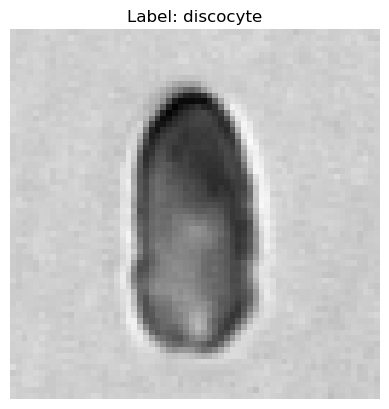

In [18]:
import random

# Select a random index
random_index = random.randint(0, len(x_data) - 1)

# Get the image and label
random_image = x_data[random_index]
random_label = y_data[random_index]

# Display the image with its label
plt.imshow(random_image)
plt.title(f"Label: {random_label}")
plt.axis("off")
plt.show()

In [19]:
def create_encoder(representation_dim):
    encoder = keras.Sequential(
        [
            keras.applications.EfficientNetB0(
                include_top=False, weights=None, pooling="avg"
            ),
            layers.Dense(representation_dim),
        ]
    )
    return encoder

In [20]:
class RepresentationLearner(keras.Model):
    def __init__(
        self,
        encoder,
        projection_units,
        num_augmentations,
        temperature=1.0,
        dropout_rate=0.1,
        l2_normalize=False,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.encoder = encoder
        # Create projection head.
        self.projector = keras.Sequential(
            [
                layers.Dropout(dropout_rate),
                layers.Dense(units=projection_units, use_bias=False),
                layers.BatchNormalization(),
                layers.ReLU(),
            ]
        )
        self.num_augmentations = num_augmentations
        self.temperature = temperature
        self.l2_normalize = l2_normalize
        self.loss_tracker = keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def compute_contrastive_loss(self, feature_vectors, batch_size):
        num_augmentations = keras.ops.shape(feature_vectors)[0] // batch_size
        if self.l2_normalize:
            feature_vectors = keras.utils.normalize(feature_vectors)
        # The logits shape is [num_augmentations * batch_size, num_augmentations * batch_size].
        logits = (
            tf.linalg.matmul(feature_vectors, feature_vectors, transpose_b=True)
            / self.temperature
        )
        # Apply log-max trick for numerical stability.
        logits_max = keras.ops.max(logits, axis=1)
        logits = logits - logits_max
        # The shape of targets is [num_augmentations * batch_size, num_augmentations * batch_size].
        # targets is a matrix consits of num_augmentations submatrices of shape [batch_size * batch_size].
        # Each [batch_size * batch_size] submatrix is an identity matrix (diagonal entries are ones).
        targets = keras.ops.tile(
            tf.eye(batch_size), [num_augmentations, num_augmentations]
        )
        # Compute cross entropy loss
        return keras.losses.categorical_crossentropy(
            y_true=targets, y_pred=logits, from_logits=True
        )

    def call(self, inputs):
        # Preprocess the input images.
        preprocessed = data_preprocessing(inputs)
        # Create augmented versions of the images.
        augmented = []
        for _ in range(self.num_augmentations):
            augmented.append(data_augmentation(preprocessed))
        augmented = layers.Concatenate(axis=0)(augmented)
        # Generate embedding representations of the images.
        features = self.encoder(augmented)
        # Apply projection head.
        return self.projector(features)

    def train_step(self, inputs):
        batch_size = keras.ops.shape(inputs)[0]
        # Run the forward pass and compute the contrastive loss
        with tf.GradientTape() as tape:
            feature_vectors = self(inputs, training=True)
            loss = self.compute_contrastive_loss(feature_vectors, batch_size)
        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update loss tracker metric
        self.loss_tracker.update_state(loss)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, inputs):
        batch_size = keras.ops.shape(inputs)[0]
        feature_vectors = self(inputs, training=False)
        loss = self.compute_contrastive_loss(feature_vectors, batch_size)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

In [ ]:
# Create vision encoder.
encoder = create_encoder(representation_dim)
# Create representation learner.
representation_learner = RepresentationLearner(
    encoder, projection_units, num_augmentations=2, temperature=0.1
)
# Create a a Cosine decay learning rate scheduler.
lr_scheduler = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.001, decay_steps=500, alpha=0.1
)
# Compile the model.
representation_learner.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=lr_scheduler, weight_decay=0.0001),
    jit_compile=False,
)
# Fit the model.
history = representation_learner.fit(
    x=x_data,
    batch_size=124,
    epochs=500,  # for better results, increase the number of epochs to 500.
)

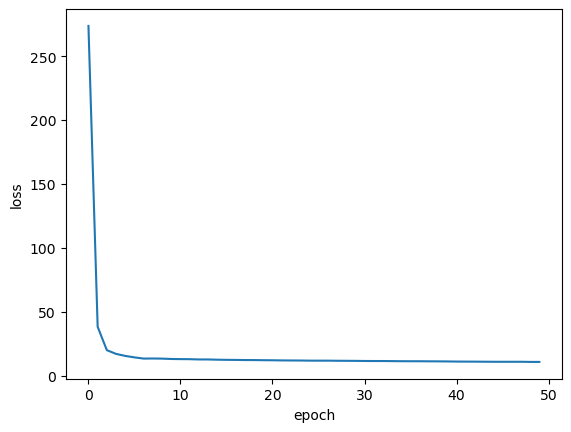

In [ ]:
plt.plot(history.history["loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

In [ ]:
batch_size = 500
# Get the feature vector representations of the images.
feature_vectors = encoder.predict(x_data, batch_size=batch_size, verbose=1)
# Normalize the feature vectores.
feature_vectors = keras.utils.normalize(feature_vectors)

I0000 00:00:1739053650.217553 2554270 service.cc:148] XLA service 0x7f70ec04ff50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739053650.217607 2554270 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-02-08 23:27:30.289070: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-08 23:27:37.807532: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng12{k11=0} for conv (f32[500,2048,2,2]{3,2,1,0}, u8[0]{0}) custom-call(f32[500,1024,2,2]{3,2,1,0}, f32[2048,1024,1,1]{3,2,1,0}, f32[2048]{0}, f32[500,2048,2,2]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":1},"force_earlie

2/5 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step

I0000 00:00:1739053661.019362 2554270 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step


In [ ]:
neighbours = []
num_batches = feature_vectors.shape[0] // batch_size
for batch_idx in tqdm(range(num_batches)):
    start_idx = batch_idx * batch_size
    end_idx = start_idx + batch_size
    current_batch = feature_vectors[start_idx:end_idx]
    # Compute the dot similarity.
    similarities = tf.linalg.matmul(current_batch, feature_vectors, transpose_b=True)
    # Get the indices of most similar vectors.
    _, indices = keras.ops.top_k(similarities, k=k_neighbours + 1, sorted=True)
    # Add the indices to the neighbours.
    neighbours.append(indices[..., 1:])

neighbours = np.reshape(np.array(neighbours), (-1, k_neighbours))

100%|██████████| 5/5 [00:00<00:00, 175.19it/s]


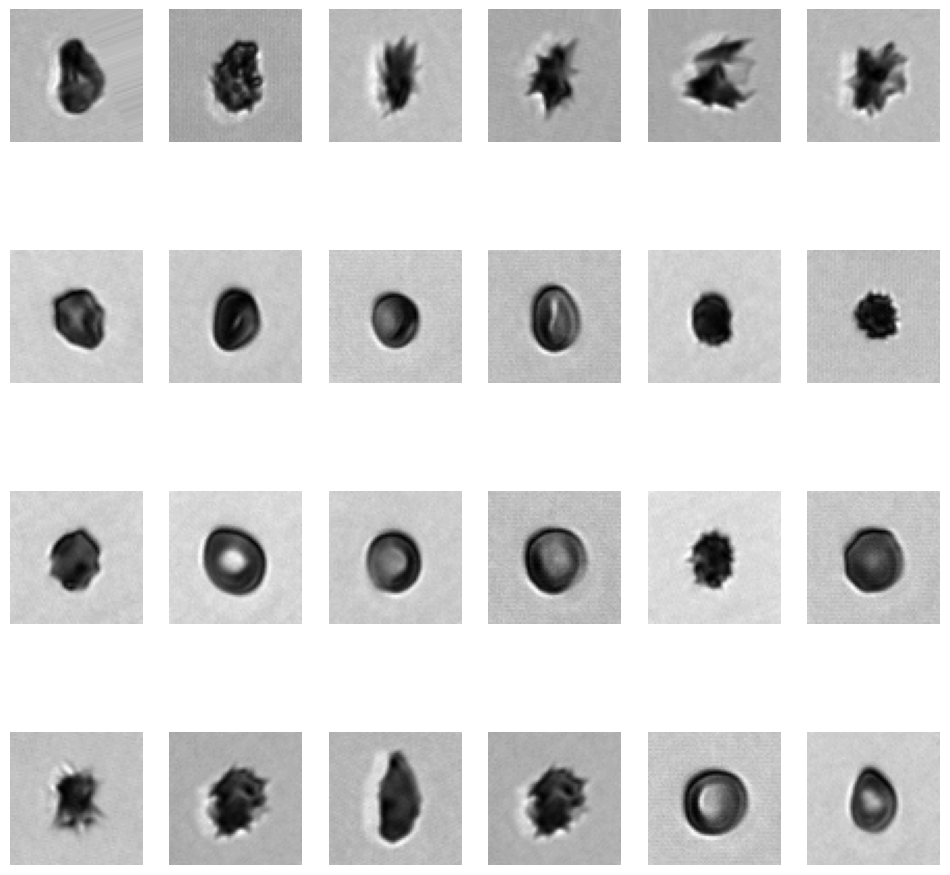

In [ ]:
nrows = 4
ncols = k_neighbours + 1

plt.figure(figsize=(12, 12))
position = 1
for _ in range(nrows):
    anchor_idx = np.random.choice(range(x_data.shape[0]))
    neighbour_indicies = neighbours[anchor_idx]
    indices = [anchor_idx] + neighbour_indicies.tolist()
    for j in range(ncols):
        plt.subplot(nrows, ncols, position)
        plt.imshow(x_data[indices[j]].astype("uint8"))
        # plt.title(classes[y_data[indices[j]]])
        plt.axis("off")
        position += 1

In [ ]:
class ClustersConsistencyLoss(keras.losses.Loss):
    def __init__(self):
        super().__init__()

    def __call__(self, target, similarity, sample_weight=None):
        # Set targets to be ones.
        target = keras.ops.ones_like(similarity)
        # Compute cross entropy loss.
        loss = keras.losses.binary_crossentropy(
            y_true=target, y_pred=similarity, from_logits=True
        )
        return keras.ops.mean(loss)


class ClustersEntropyLoss(keras.losses.Loss):
    def __init__(self, entropy_loss_weight=1.0):
        super().__init__()
        self.entropy_loss_weight = entropy_loss_weight

    def __call__(self, target, cluster_probabilities, sample_weight=None):
        # Ideal entropy = log(num_clusters).
        num_clusters = keras.ops.cast(
            keras.ops.shape(cluster_probabilities)[-1], "float32"
        )
        target = keras.ops.log(num_clusters)
        # Compute the overall clusters distribution.
        cluster_probabilities = keras.ops.mean(cluster_probabilities, axis=0)
        # Replacing zero probabilities - if any - with a very small value.
        cluster_probabilities = keras.ops.clip(cluster_probabilities, 1e-8, 1.0)
        # Compute the entropy over the clusters.
        entropy = -keras.ops.sum(
            cluster_probabilities * keras.ops.log(cluster_probabilities)
        )
        # Compute the difference between the target and the actual.
        loss = target - entropy
        return loss

In [ ]:
def create_clustering_model(encoder, num_clusters, name=None):
    inputs = keras.Input(shape=input_shape)
    # Preprocess the input images.
    preprocessed = data_preprocessing(inputs)
    # Apply data augmentation to the images.
    augmented = data_augmentation(preprocessed)
    # Generate embedding representations of the images.
    features = encoder(augmented)
    # Assign the images to clusters.
    outputs = layers.Dense(units=num_clusters, activation="softmax")(features)
    # Create the model.
    model = keras.Model(inputs=inputs, outputs=outputs, name=name)
    return model

In [ ]:
input_shape = (224, 224, 3)

In [ ]:
def create_clustering_learner(clustering_model):
    anchor = keras.Input(shape=input_shape, name="anchors")
    neighbours = keras.Input(
        shape=tuple([k_neighbours]) + input_shape, name="neighbours"
    )
    # Changes neighbours shape to [batch_size * k_neighbours, width, height, channels]
    neighbours_reshaped = keras.ops.reshape(neighbours, tuple([-1]) + input_shape)
    # anchor_clustering shape: [batch_size, num_clusters]
    anchor_clustering = clustering_model(anchor)
    # neighbours_clustering shape: [batch_size * k_neighbours, num_clusters]
    neighbours_clustering = clustering_model(neighbours_reshaped)
    # Convert neighbours_clustering shape to [batch_size, k_neighbours, num_clusters]
    neighbours_clustering = keras.ops.reshape(
        neighbours_clustering,
        (-1, k_neighbours, keras.ops.shape(neighbours_clustering)[-1]),
    )
    # similarity shape: [batch_size, 1, k_neighbours]
    similarity = keras.ops.einsum(
        "bij,bkj->bik",
        keras.ops.expand_dims(anchor_clustering, axis=1),
        neighbours_clustering,
    )
    # similarity shape:  [batch_size, k_neighbours]
    similarity = layers.Lambda(
        lambda x: keras.ops.squeeze(x, axis=1), name="similarity"
    )(similarity)
    # Create the model.
    model = keras.Model(
        inputs=[anchor, neighbours],
        outputs=[similarity, anchor_clustering],
        name="clustering_learner",
    )
    return model

In [ ]:
# If tune_encoder_during_clustering is set to False,
# then freeze the encoder weights.
for layer in encoder.layers:
    layer.trainable = tune_encoder_during_clustering
# Create the clustering model and learner.
clustering_model = create_clustering_model(encoder, num_clusters, name="clustering")
clustering_learner = create_clustering_learner(clustering_model)
# Instantiate the model losses.
losses = [ClustersConsistencyLoss(), ClustersEntropyLoss(entropy_loss_weight=5)]
# Create the model inputs and labels.
inputs = {"anchors": x_data, "neighbours": tf.gather(x_data, neighbours)}
# labels = np.ones(shape=(x_data.shape[0]))

labels = [
    np.ones(shape=(x_data.shape[0], k_neighbours)),  # Corresponds to similarity
    np.ones(shape=(x_data.shape[0], num_clusters)),  # Corresponds to anchor_clustering
]
# labels[1] = keras.utils.to_categorical(labels[1], num_classes=num_clusters)
# Compile the model.
clustering_learner.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=0.0005, weight_decay=0.0001),
    loss=losses,
    jit_compile=False,
)

In [ ]:
# Begin training the model.
clustering_learner.fit(x=inputs, y=labels, batch_size=512, epochs=50)

Epoch 1/50


5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - clustering_loss: 0.1263 - loss: 0.7871 - similarity_loss: 0.6605
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 244ms/step - clustering_loss: 0.0435 - loss: 0.7095 - similarity_loss: 0.6659
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 244ms/step - clustering_loss: 0.0140 - loss: 0.6817 - similarity_loss: 0.6677
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step - clustering_loss: 0.0037 - loss: 0.6720 - similarity_loss: 0.6682
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step - clustering_loss: 0.0017 - loss: 0.6700 - similarity_loss: 0.6683
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step - clustering_loss: 0.0021 - loss: 0.6704 - similarity_loss: 0.6683
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step - clustering_loss: 0.0020 - loss: 0.6703 - similarity_loss: 0.6683
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step - clustering_loss: 0.0018 - loss: 0.6701 - similarity_loss: 0.6683
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step - clustering_loss: 0.0014 -

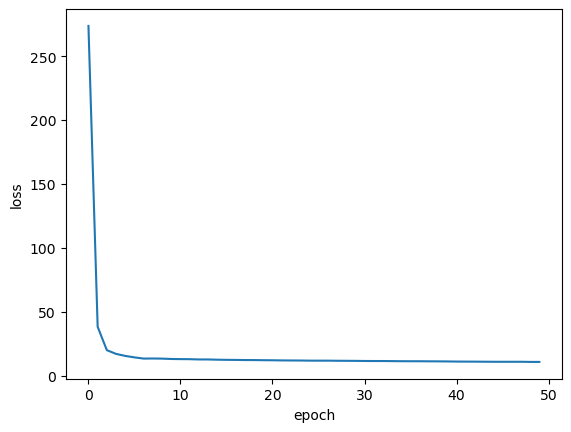

In [ ]:
plt.plot(history.history["loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

In [ ]:
# Get the cluster probability distribution of the input images.
clustering_probs = clustering_model.predict(x_data, batch_size=batch_size, verbose=1)
# Get the cluster of the highest probability.
cluster_assignments = keras.ops.argmax(clustering_probs, axis=-1).numpy()
# Store the clustering confidence.
# Images with the highest clustering confidence are considered the 'prototypes'
# of the clusters.
cluster_confidence = keras.ops.max(clustering_probs, axis=-1).numpy()

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step


In [ ]:
clusters = defaultdict(list)
for idx, c in enumerate(cluster_assignments):
    clusters[c].append((idx, cluster_confidence[idx]))

non_empty_clusters = defaultdict(list)
for c in clusters.keys():
    if clusters[c]:
        non_empty_clusters[c] = clusters[c]

for c in range(num_clusters):
    print("cluster", c, ":", len(clusters[c]))

cluster 0 : 18
cluster 1 : 19
cluster 2 : 655
cluster 3 : 757
cluster 4 : 203
cluster 5 : 6
cluster 6 : 4
cluster 7 : 47
cluster 8 : 127
cluster 9 : 4
cluster 10 : 0
cluster 11 : 3
cluster 12 : 1
cluster 13 : 141
cluster 14 : 51
cluster 15 : 32
cluster 16 : 207
cluster 17 : 4
cluster 18 : 221
cluster 19 : 0


IndexError: list index out of range

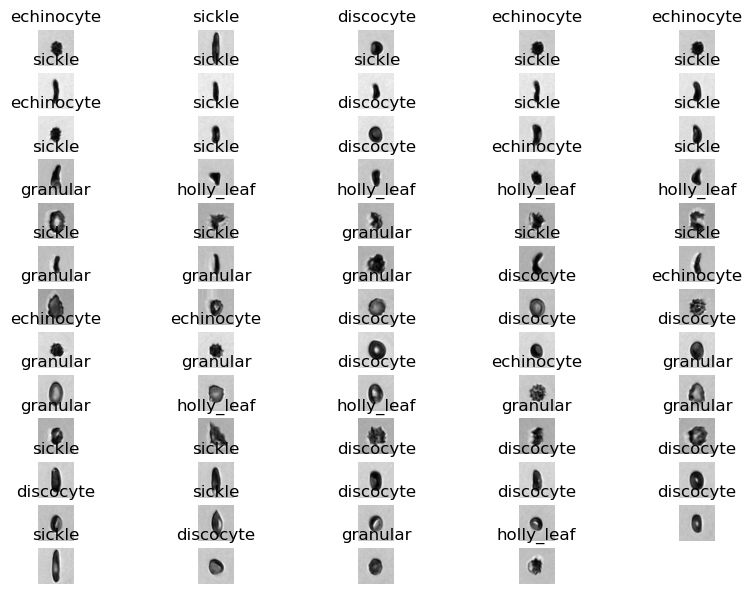

In [ ]:
num_images = 5
plt.figure(figsize=(10, 10))
position = 1
for c in non_empty_clusters.keys():
    cluster_instances = sorted(
        non_empty_clusters[c], key=lambda kv: kv[1], reverse=True
    )

    for j in range(num_images):
        image_idx = cluster_instances[j][0]
        plt.subplot(len(non_empty_clusters), num_images, position)
        plt.imshow(x_data[image_idx].astype("uint8"))
        plt.title(y_data[image_idx])
        plt.axis("off")
        position += 1

In [ ]:
num_classes = len(np.unique(y_data))
cluster_label_counts = dict()

for c in range(num_clusters):
    cluster_label_counts[c] = [0] * num_classes
    instances = clusters[c]
    for i, _ in instances:
        label_index = classes.index(y_data[i])
        cluster_label_counts[c][label_index] += 1

    cluster_label_idx = np.argmax(cluster_label_counts[c])
    correct_count = np.max(cluster_label_counts[c])
    cluster_size = len(clusters[c])
    accuracy = (
        np.round((correct_count / cluster_size) * 100, 2) if cluster_size > 0 else 0
    )
    cluster_label = classes[cluster_label_idx]
    print("cluster", c, "label is:", cluster_label, " -  accuracy:", accuracy, "%")

cluster 0 label is: discocyte  -  accuracy: 38.89 %
cluster 1 label is: granular  -  accuracy: 42.11 %
cluster 2 label is: discocyte  -  accuracy: 40.46 %
cluster 3 label is: holly_leaf  -  accuracy: 38.18 %
cluster 4 label is: granular  -  accuracy: 36.95 %
cluster 5 label is: discocyte  -  accuracy: 83.33 %
cluster 6 label is: granular  -  accuracy: 75.0 %
cluster 7 label is: sickle  -  accuracy: 91.49 %
cluster 8 label is: sickle  -  accuracy: 56.69 %
cluster 9 label is: granular  -  accuracy: 50.0 %
cluster 10 label is: discocyte  -  accuracy: 0 %
cluster 11 label is: granular  -  accuracy: 100.0 %
cluster 12 label is: sickle  -  accuracy: 100.0 %
cluster 13 label is: sickle  -  accuracy: 51.06 %
cluster 14 label is: granular  -  accuracy: 58.82 %
cluster 15 label is: sickle  -  accuracy: 43.75 %
cluster 16 label is: holly_leaf  -  accuracy: 31.4 %
cluster 17 label is: discocyte  -  accuracy: 25.0 %
cluster 18 label is: discocyte  -  accuracy: 33.48 %
cluster 19 label is: discocyte

In [ ]:
num_classes

5

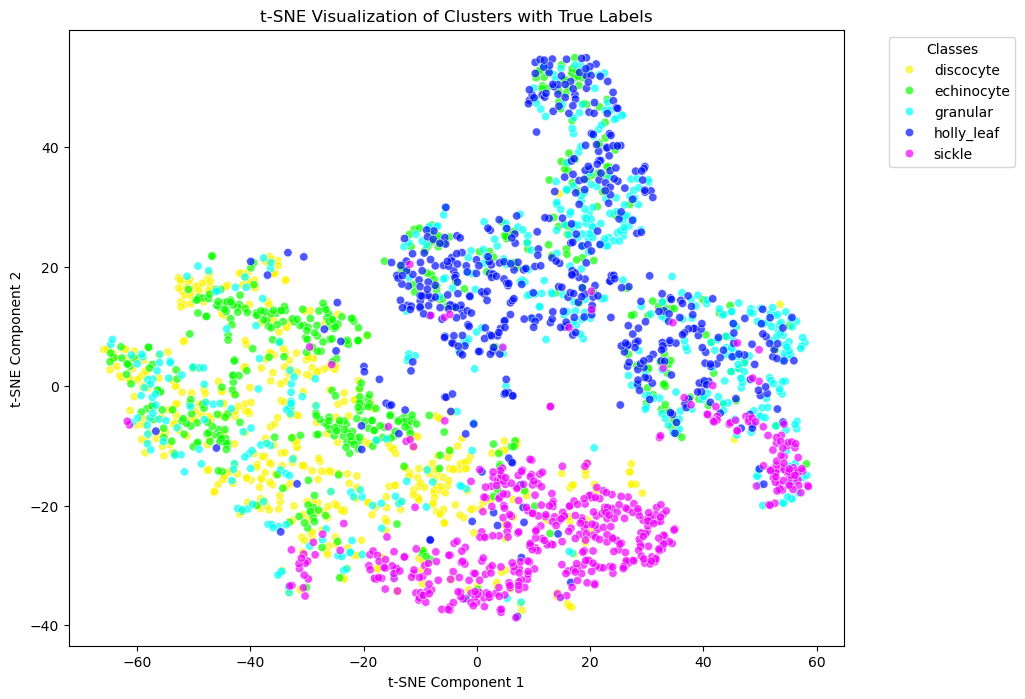

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Reduce dimensions using t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
feature_vectors_2d = tsne.fit_transform(feature_vectors)

# Convert labels from (N,1) shape to (N,)
y_data_flat = y_data.flatten()

# Define a color palette
palette = sns.color_palette("hsv", num_classes)

# Plot the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=feature_vectors_2d[:, 0],
    y=feature_vectors_2d[:, 1],
    hue=y_data_flat,
    palette=palette,
    legend="full",
    alpha=0.7,
)

# Add title and legend
plt.title("t-SNE Visualization of Clusters with True Labels")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

/home/t.afanasyeva/miniforge3/envs/IMG/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/t.afanasyeva/miniforge3/envs/IMG/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/t.afanasyeva/miniforge3/envs/IMG/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipykernel_2553901/39493314.py:9: UserWarning: The palette list has more values (20) than needed (18), which may not be intended.
  sns.scatterplot(


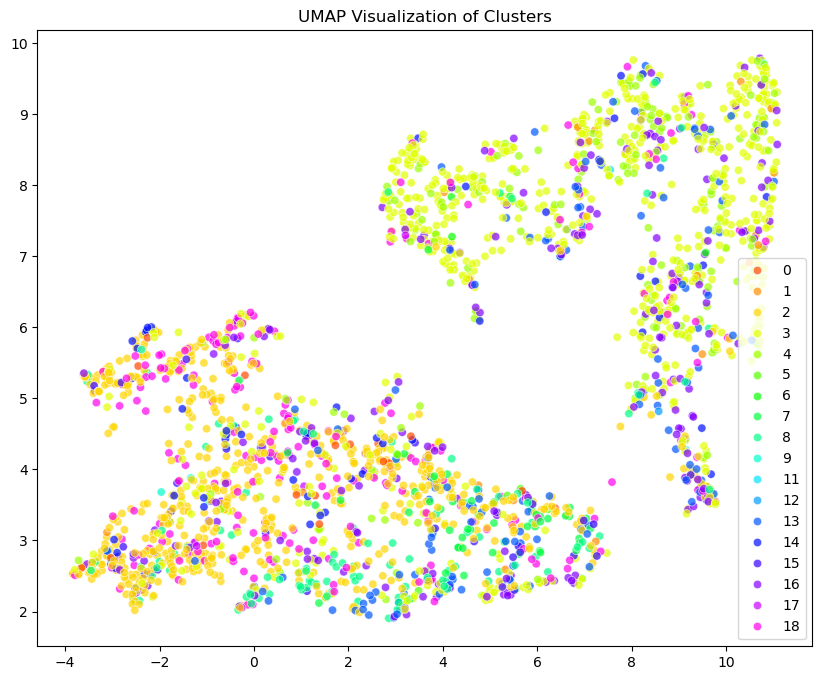

In [ ]:
import umap

# Reduce dimensions using UMAP
umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
feature_vectors_2d = umap_reducer.fit_transform(feature_vectors)

# Plot clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=feature_vectors_2d[:, 0],
    y=feature_vectors_2d[:, 1],
    hue=cluster_labels,
    palette=sns.color_palette("hsv", num_clusters),
    alpha=0.7,
)
plt.title("UMAP Visualization of Clusters")
plt.show()

/home/t.afanasyeva/miniforge3/envs/IMG/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/t.afanasyeva/miniforge3/envs/IMG/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


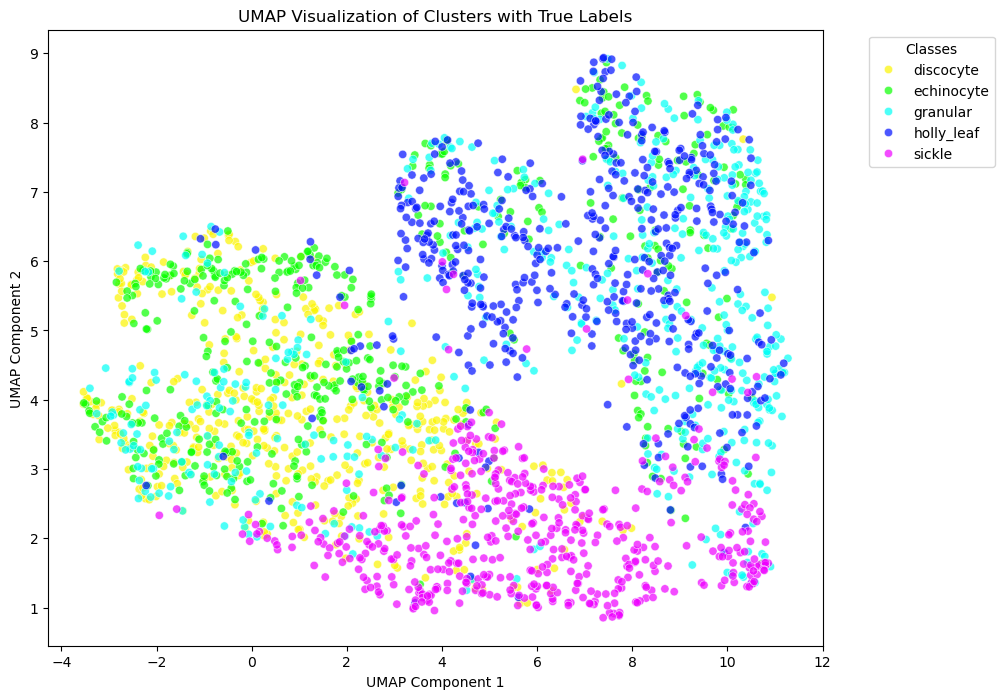

In [ ]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns

# Reduce dimensions using UMAP
umap_model = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.3, random_state=42)
feature_vectors_2d = umap_model.fit_transform(feature_vectors)

# Convert labels from (N,1) shape to (N,)
y_data_flat = y_data.flatten()

# Define a color palette
palette = sns.color_palette("hsv", num_classes)

# Plot the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=feature_vectors_2d[:, 0],
    y=feature_vectors_2d[:, 1],
    hue=y_data_flat,
    palette=palette,
    legend="full",
    alpha=0.7,
)

# Add title and legend
plt.title("UMAP Visualization of Clusters with True Labels")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()